In [1]:
import pandas as pd
import numpy as np
from selenium.webdriver.support.expected_conditions import element_to_be_selected

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [2]:
def run_regression(data, drop_columns, target):
    X = data.drop(drop_columns, axis=1)
    y = data[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Min-Max Scaler
    scaler = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both the training and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the regression algorithms
    regressors = {
        'Linear Regression': LinearRegression(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }
    
    # Initialize a dictionary to store results
    results = {}
    
    # Train and evaluate each regressor
    for name, regressor in regressors.items():
        # Train the model
        regressor.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = regressor.predict(X_test_scaled)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results).T
    
    # Print the report
    print("Regression Algorithms Performance Report:")
    print(results_df)

In [61]:
def preprocess_data(data, params_filter):
    data_processed = data.copy()
    data_processed = data_processed[data_processed['CT Água'] != 0]
    
    data_processed['AC'] = data_processed['CT Água'] / data_processed['CT Cimento']
    
    try:
        data_processed = data_processed.drop(columns = ['Planta', 'Empresa']) # remove "empresa" and "planta"
    except:
        data_processed = data_processed
    
    for c in data_processed:
        try:
            data_processed[c] = data_processed[c].astype(float)
        except:
            # data_processed[c] = data_processed[c]
            print(f'Feature {c} não é numerica\n')
    
    for feat, lim in params_filter.items():
        data_processed = data_processed[data_processed[feat] < lim]

    columns_all_zero = data_processed.columns[(data_processed == 0).all()]
    data_processed = data_processed.drop(columns=columns_all_zero)
    
    data_processed = data_processed.drop_duplicates()
    
    instances_per_class = data_processed.groupby(['cimento Tipo', 'cimento Classe de resistência']).count()['Fck'].reset_index()

    keep_instances = instances_per_class[instances_per_class['Fck'] > 10].reset_index()

    data_processed = data_processed[data_processed['cimento Tipo'].isin(keep_instances['cimento Tipo'])]
    
    
    data_processed['Brita_total'] = data_processed['CT Brita 0'] + data_processed['CT Brita 1']
    data_processed['Areia_total'] = data_processed['CT Areia natural'] + data_processed['CT Areia artificial']
    data_processed['Agregados'] = data_processed['Brita_total'] + data_processed['Areia_total']

    for c in ['CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'Brita_total', 'Areia_total',
              'Agregados']:
        data_processed[c + '_Cimento'] = data_processed[c] / data_processed['CT Cimento']
    
    return data_processed


In [4]:
def apply_standardization_filter(data, remove_params):
    # TODO: implement filter to verify class/fck_min
    # concrete_class = 'CP V'
    # age = '7_days'
    
    data_processed = data.copy() # Caso precise incluir features
    
    # Feature analysed: 'Fck'
    for feat, lim in remove_params.items():
        print(f'{"Instâncias eliminadas devido a falta de representatividade (Fck = " + feat + " MPA):" :<90}', len(data_processed[data_processed['Fck'] == lim]))
        data_processed = data_processed[data_processed['Fck'] != lim]
        
    
    # Feature analysed: 'AC'
    print(f'{"Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):" :<90}', len(data_processed[data_processed['AC'] > 0.65]))
    data_processed = data_processed[data_processed['AC'] <= 0.65]
    
    # Feature analysed: 'Fc 28d'
    ## Precisa de análise mais detalhada!!!
    data_processed['Status'] = np.where(data_processed['Fc 28d'] >= data_processed['Fck'], 1, 0)
    print(f'{"Instâncias eliminadas devido não conformidade resistência especificada:" : <90}', len(data_processed[data_processed['Status'] == 0]))
    data_processed = data_processed[data_processed['Status'] == 1]
    
    data_processed.drop(columns = ['Status'], inplace = True)
    
    return data_processed

In [5]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

def run_regression_CV(data, drop_columns, target, n_splits=5):
    X = data.drop(drop_columns, axis=1)
    y = data[target]
    
    # Initialize the Min-Max Scaler
    scaler = MinMaxScaler()
    
    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Define the regression algorithms
    regressors = {
        'Linear Regression': LinearRegression(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }
    
    # Initialize a dictionary to store results
    results = {name: {'MAE': [], 'MSE': [], 'R2': []} for name in regressors}
    
    # Train and evaluate each regressor
    for name, regressor in regressors.items():
        mae_scores, mse_scores, r2_scores = [], [], []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Scale the data
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train the model
            regressor.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = regressor.predict(X_test_scaled)
            
            # Calculate performance metrics
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
        
        # Store mean results
        results[name]['MAE'] = sum(mae_scores) / len(mae_scores)
        results[name]['MSE'] = sum(mse_scores) / len(mse_scores)
        results[name]['R2'] = sum(r2_scores) / len(r2_scores)
    
    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results).T
    
    # Print the report
    print("Regression Algorithms Performance Report:")
    print(results_df)


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np

def calculate_aic(n, mse, k):
    """
    Calculate AIC based on number of samples (n), mean squared error (mse), 
    and number of parameters (k).
    """
    return n * np.log(mse) + 2 * k

def aic_scorer(estimator, X, y):
    """
    Custom AIC scorer to be used in GridSearchCV.
    """
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    n = len(y)  # number of samples
    k = X.shape[1]  # number of features/parameters
    aic = calculate_aic(n, mse, k)
    return -aic  # Since GridSearchCV maximizes the score, return negative AIC

def grid_search_FS_RF(X, y, param_grid_rf):
    # Define multiple metrics for regression
    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
        'aic': aic_scorer  # Custom AIC scorer
    }

    # Initialize RandomForestRegressor
    rf = RandomForestRegressor(random_state=42)

    # Set up KFold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Set up GridSearchCV for RandomForestRegressor
    grid_search_rf = GridSearchCV(
        estimator=rf,  # Just RandomForestRegressor
        param_grid=param_grid_rf,
        cv=kfold,
        scoring=scoring,  # Use multiple metrics including AIC
        refit='aic',  # The metric to use for the final model selection
        verbose=1
    )

    # Fit the grid search for RandomForestRegressor
    grid_search_rf.fit(X, y)

    # Get the best RandomForestRegressor parameters
    best_rf = grid_search_rf.best_params_
    print("Best parameters for RandomForestRegressor: ", best_rf)
    
    # Get the best estimator (the one that gave the best result)
    best_model = grid_search_rf.best_estimator_
    
    # Get the feature importances from the best model
    feature_importances = best_model.feature_importances_
    
    # Create a DataFrame for better readability
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances for the Best Model:")
    print(feature_importances_df)
    
    return grid_search_rf, feature_importances_df


In [7]:
def regression_train_val(X_tr, X_ts, y_tr, y_ts):  
    # Initialize the Min-Max Scaler
    scaler = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both the training and test data
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_ts)
    
    # Define the regression algorithms
    regressors = {
        'Linear Regression': LinearRegression(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }
    
    # Initialize a dictionary to store results
    results = {}
    
    # Train and evaluate each regressor
    for name, regressor in regressors.items():
        # Train the model
        regressor.fit(X_train_scaled, y_tr)
        
        # Make predictions
        y_pred = regressor.predict(X_test_scaled)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_ts, y_pred)
        mse = mean_squared_error(y_ts, y_pred)
        r2 = r2_score(y_ts, y_pred)
        
        # Store results
        results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results).T
    
    # Print the report
    print("Regression Algorithms Performance Report:")
    print(results_df)

In [8]:
data = pd.read_excel('data/Concreto_IACC.xlsx')
data

,Empresa,Planta,Nota Fiscal,Volume,Nome produto,Código do produto,Data,Horário,Cidade,Nome Central,...,CT Plastificante,CT Polifuncional,CT Superplastificante,CT Incorporador de ar,CT Brita 0,CT Brita 1,CT Brita 2,CT Areia natural,CT Areia artificial,CT Água
0,305,A,27992,8.0,NaN,44341.0,NaN,NaN,Anapolis,Anapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,305,A,27996,8.0,NaN,44341.0,NaN,NaN,Anapolis,Anapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,305,A,33842,6.0,NaN,44525.0,NaN,NaN,Anapolis,Anapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215
3,305,A,33046,3.5,NaN,44496.0,NaN,NaN,Anapolis,Anapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216
4,305,A,42011,6.0,NaN,44774.0,NaN,NaN,Anapolis,Anapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236402,303,Z,74824,8.0,NaN,6055079.0,19/10/2021,15:59:24,BRASÍLIA,BRASÍLIA,...,NaN,3.672,NaN,NaN,1000.0,NaN,NaN,356,450,216.5
236403,303,Z,82901,8.0,NaN,6173088.0,20/02/2023,08:07:39,BRASÍLIA,BRASÍLIA,...,NaN,4.24,NaN,NaN,203.0,814,NaN,317,405,218
236404,303,Z,76483,8.0,NaN,6054456.0,13/01/2022,07:37:00,BRASÍLIA,BRASÍLIA,...,NaN,3.302,NaN,NaN,987.0,NaN,NaN,354,447,219
236405,303,Z,76284,8.0,NaN,6165910.0,29/12/2021,17:48:42,BRASÍLIA,BRASÍLIA,...,NaN,3.302,NaN,NaN,987.0,NaN,NaN,354,447,219


In [9]:
df_cimento = data[~data['cimento Classe de resistência'].isna()]
df_cimento.rename(columns = {'CT Água ' : 'CT Água'})

df_cimento.columns = ['Empresa', 'Planta', 'Nota Fiscal', 'Volume', 'Nome produto',
       'Código do produto', 'Data', 'Horário', 'Cidade', 'Nome Central',
       'cimento Tipo', 'cimento Classe de resistência',
       'cimento Resistência real 3d', 'cimento Resistência real 7d',
       'cimento Resistência real 28d', 'cimento Fornecedor', 'cimento Cidade',
       'concreto Cimento', 'concreto Fíler calcário', 'concreto Cinza volante',
       'concreto Escória', 'concreto Argila calcinada', 'concreto Silica',
       'concreto Plastificante', 'concreto Polifuncional',
       'concreto Superplastificante', 'concreto Incorporador de ar',
       'concreto Brita 0', 'concreto Brita 1', 'concreto Brita 2',
       'concreto Areia natural', 'concreto Areia artificial',
       'concreto Água (automação)', 'concreto Água (ponto de carga)',
       'concreto Água (lastro de retorno)', 'concreto Água caminhão',
       'concreto Umidade brita 0', 'concreto Umidade brita 1',
       'concreto Umidade brita 2', 'concreto Umidade areia natural',
       'concreto Umidade areia artificial', 'Mesp Brita 0', 'Mesp Brita 1',
       'Mesp Brita 2', 'Mesp Areia natural', 'Mesp Areia artificial',
       'Tempo de transporte', 'Temperatura ambiente', 'Slump', 'Fc 1d',
       'Fc 3d', 'Fc 7d', 'Fc 28d', 'Fck', 'CT Cimento', 'CT Fíler calcário',
       'CT Cinza volante', 'CT Escória', 'CT Argila calcinada', 'CT Silica',
       'CT Plastificante', 'CT Polifuncional', 'CT Superplastificante',
       'CT Incorporador de ar', 'CT Brita 0', 'CT Brita 1', 'CT Brita 2',
       'CT Areia natural', 'CT Areia artificial', 'CT Água']
 
df_cimento

,Empresa,Planta,Nota Fiscal,Volume,Nome produto,Código do produto,Data,Horário,Cidade,Nome Central,...,CT Plastificante,CT Polifuncional,CT Superplastificante,CT Incorporador de ar,CT Brita 0,CT Brita 1,CT Brita 2,CT Areia natural,CT Areia artificial,CT Água
12080,303,AA,49654,8.0,NaN,6054392.0,07/10/2021,14:11:37,SÃO JOSÉ DO RIO PRETO,SÃO JOSÉ DO RIO PRETO,...,NaN,2.024,NaN,NaN,1074.0,NaN,NaN,889,NaN,193
12081,303,AA,50407,8.0,NaN,6054444.0,22/11/2021,09:35:14,SÃO JOSÉ DO RIO PRETO,SÃO JOSÉ DO RIO PRETO,...,NaN,2.176,NaN,NaN,283.0,851,NaN,841,NaN,186
12082,303,AA,49613,8.0,NaN,6054400.0,06/10/2021,11:18:42,SÃO JOSÉ DO RIO PRETO,SÃO JOSÉ DO RIO PRETO,...,NaN,1.94,NaN,NaN,339.0,794,NaN,866,NaN,185
12083,303,AA,49657,5.5,NaN,6054392.0,07/10/2021,15:37:02,SÃO JOSÉ DO RIO PRETO,SÃO JOSÉ DO RIO PRETO,...,NaN,2.024,NaN,NaN,1074.0,NaN,NaN,889,NaN,193
12084,303,AA,49604,8.0,NaN,6054400.0,06/10/2021,07:31:10,SÃO JOSÉ DO RIO PRETO,SÃO JOSÉ DO RIO PRETO,...,NaN,1.94,NaN,NaN,339.0,794,NaN,866,NaN,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236402,303,Z,74824,8.0,NaN,6055079.0,19/10/2021,15:59:24,BRASÍLIA,BRASÍLIA,...,NaN,3.672,NaN,NaN,1000.0,NaN,NaN,356,450,216.5
236403,303,Z,82901,8.0,NaN,6173088.0,20/02/2023,08:07:39,BRASÍLIA,BRASÍLIA,...,NaN,4.24,NaN,NaN,203.0,814,NaN,317,405,218
236404,303,Z,76483,8.0,NaN,6054456.0,13/01/2022,07:37:00,BRASÍLIA,BRASÍLIA,...,NaN,3.302,NaN,NaN,987.0,NaN,NaN,354,447,219
236405,303,Z,76284,8.0,NaN,6165910.0,29/12/2021,17:48:42,BRASÍLIA,BRASÍLIA,...,NaN,3.302,NaN,NaN,987.0,NaN,NaN,354,447,219


In [10]:
df_concreto = df_cimento[['Empresa', 'Planta', 'Nota Fiscal',
'Data', 'Horário', 'Cidade', 
'cimento Tipo', 'cimento Classe de resistência',
'concreto Cimento', 'concreto Fíler calcário', 'concreto Cinza volante',
'concreto Escória', 'concreto Argila calcinada', 'concreto Silica',
'concreto Plastificante', 'concreto Polifuncional',
'concreto Superplastificante', 'concreto Incorporador de ar',
'concreto Brita 0', 'concreto Brita 1', 'concreto Brita 2',
'concreto Areia natural', 'concreto Areia artificial',
'concreto Água (automação)', 'concreto Água (ponto de carga)',
'concreto Água (lastro de retorno)', 'concreto Água caminhão',
'concreto Umidade brita 0', 'concreto Umidade brita 1',
'concreto Umidade brita 2', 'concreto Umidade areia natural',
'concreto Umidade areia artificial', 'Mesp Brita 0', 'Mesp Brita 1',
'Mesp Brita 2', 'Mesp Areia natural', 'Mesp Areia artificial',
'Tempo de transporte', 'Temperatura ambiente', 'Slump', 'Fc 1d',
'Fc 3d', 'Fc 7d', 'Fc 28d', 'Fck', 'CT Cimento', 'CT Fíler calcário',
'CT Cinza volante', 'CT Escória', 'CT Argila calcinada', 'CT Silica',
'CT Plastificante', 'CT Polifuncional', 'CT Superplastificante',
'CT Incorporador de ar', 'CT Brita 0', 'CT Brita 1', 'CT Brita 2',
'CT Areia natural', 'CT Areia artificial', 'CT Água']]

# df_concreto = df_concreto.dropna(axis=1, how='all')

missing_percentage = df_concreto.isna().mean() * 100
dropout_columns_NA = missing_percentage[missing_percentage > 70].index

missing_percentage[missing_percentage > 20]

concreto Cimento                      47.730814
concreto Fíler calcário              100.000000
concreto Cinza volante               100.000000
concreto Escória                     100.000000
concreto Argila calcinada            100.000000
concreto Silica                      100.000000
concreto Plastificante                96.698481
concreto Polifuncional                55.619400
concreto Superplastificante           98.802104
concreto Incorporador de ar           99.851967
concreto Brita 0                      49.505259
concreto Brita 1                      65.372030
concreto Brita 2                     100.000000
concreto Areia natural                47.760031
concreto Areia artificial             60.670043
concreto Água (automação)            100.000000
concreto Água (ponto de carga)       100.000000
concreto Água (lastro de retorno)    100.000000
concreto Água caminhão               100.000000
concreto Umidade brita 0              49.505259
concreto Umidade brita 1              65

In [11]:
# df_concreto[df_concreto.columns[~df_concreto.columns.isin(dropout_columns_NA)]]
# 
# df_concreto[['concreto Cimento', 'CT Cimento']].describe()
# 
# diff = df_concreto['concreto Cimento'] - df_concreto['CT Cimento']
# diff[diff**2 > 5]

In [12]:
df_concreto_traco = df_concreto[['Empresa', 'Planta', 
                                 # 'Data', 'Horário', 'Cidade',
                                 'cimento Tipo', 'cimento Classe de resistência', 'Nota Fiscal',
                                 
                               #   'concreto Cimento','concreto Polifuncional', 'concreto Brita 0', 'concreto Brita 1',
                               # 'concreto Areia natural', 'concreto Areia artificial',
                               # 'concreto Umidade brita 0', 'concreto Umidade brita 1',
                               # 'concreto Umidade areia natural', 'concreto Umidade areia artificial',
                                 
                               # 'Mesp Brita 0', 'Mesp Brita 1', 'Mesp Brita 2', 'Mesp Areia natural',
                               # 'Mesp Areia artificial', 'Tempo de transporte',
                                 
                                 # 'Slump', 
                                 'Fck', 
                                 # 'Fc 1d', 'Fc 3d',
                                 'Fc 7d',
                                 
                                 'CT Cimento', 'CT Fíler calcário',
                               'CT Cinza volante', 'CT Escória', 'CT Argila calcinada', 'CT Silica',
                               'CT Plastificante', 'CT Polifuncional', 'CT Superplastificante',
                               'CT Incorporador de ar', 'CT Brita 0', 'CT Brita 1', 'CT Brita 2',
                               'CT Areia natural', 'CT Areia artificial', 'CT Água',
                                 'Fc 28d']].copy()

df_concreto_traco['CT Polifuncional'] = df_concreto_traco['CT Polifuncional'].str.replace(',,', '', regex=False)

for c in df_concreto_traco.columns[5:]:
    df_concreto_traco.loc[:, c] = df_concreto_traco.loc[:, c].replace('-', '0')
    df_concreto_traco[c] = df_concreto_traco[c].astype(float)
    df_concreto_traco.loc[:, c] = df_concreto_traco.loc[:, c].fillna(0)
    


# # Calculate the AC ratio and handle division by zero
# df_concreto_traco['AC'] = np.where(
#     df_concreto_traco['CT Água'] == 0,  # Condition for division by zero
#     -1,  # Value to assign if condition is True (division by zero)
#     df_concreto_traco['CT Cimento'] / df_concreto_traco['CT Água']  # Normal division if condition is False
# )

df_concreto_traco

,Empresa,Planta,cimento Tipo,cimento Classe de resistência,Nota Fiscal,Fck,Fc 7d,CT Cimento,CT Fíler calcário,CT Cinza volante,...,CT Polifuncional,CT Superplastificante,CT Incorporador de ar,CT Brita 0,CT Brita 1,CT Brita 2,CT Areia natural,CT Areia artificial,CT Água,Fc 28d
12080,303,AA,CP II-F,40,49654,20.0,10.8,213.0,0.0,0.0,...,0.0,0.0,0.0,1074.0,0.0,0.0,889.0,0.0,193.00,19.0
12081,303,AA,CP II-F,40,50407,20.0,11.0,229.0,0.0,0.0,...,0.0,0.0,0.0,283.0,851.0,0.0,841.0,0.0,186.00,20.1
12082,303,AA,CP II-F,40,49613,20.0,11.3,204.0,0.0,0.0,...,0.0,0.0,0.0,339.0,794.0,0.0,866.0,0.0,185.00,17.6
12083,303,AA,CP II-F,40,49657,20.0,11.4,213.0,0.0,0.0,...,0.0,0.0,0.0,1074.0,0.0,0.0,889.0,0.0,193.00,17.7
12084,303,AA,CP II-F,40,49604,20.0,11.9,204.0,0.0,0.0,...,0.0,0.0,0.0,339.0,794.0,0.0,866.0,0.0,185.00,17.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236402,303,Z,CP II-F,40,74824,30.0,0.0,334.0,0.0,0.0,...,0.0,0.0,0.0,1000.0,0.0,0.0,356.0,450.0,216.50,32.8
236403,303,Z,CP II-F,40,82901,25.0,0.0,353.0,0.0,0.0,...,0.0,0.0,0.0,203.0,814.0,0.0,317.0,405.0,218.00,31.7
236404,303,Z,CP II-F,40,76483,30.0,0.0,348.0,0.0,0.0,...,0.0,0.0,0.0,987.0,0.0,0.0,354.0,447.0,219.00,35.0
236405,303,Z,CP II-F,40,76284,30.0,0.0,348.0,0.0,0.0,...,0.0,0.0,0.0,987.0,0.0,0.0,354.0,447.0,219.00,33.8


# Pré-processamento

## Filtro "empírico"

In [13]:
# Cria variável 'A/C', converte tipos, aplica filtros que estão nos parâmetros (valores < que)
df_traco_processed = preprocess_data(data = df_concreto_traco,
                                     params_filter = {'Fc 28d': 60,
                                                     'CT Polifuncional': 1,
                                                     'CT Plastificante': 0.5})

df_traco_processed

Feature cimento Tipo não é numerica

Feature cimento Classe de resistência não é numerica



,cimento Tipo,cimento Classe de resistência,Nota Fiscal,Fck,Fc 7d,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,...,Brita_total,Areia_total,Agregados,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento,Brita_total_Cimento,Areia_total_Cimento,Agregados_Cimento
12080,CP II-F,40,49654.0,20.0,10.8,213.0,0.0,0.0,1074.0,0.0,...,1074.0,889.0,1963.0,5.042254,0.000000,4.173709,0.000000,5.042254,4.173709,9.215962
12081,CP II-F,40,50407.0,20.0,11.0,229.0,0.0,0.0,283.0,851.0,...,1134.0,841.0,1975.0,1.235808,3.716157,3.672489,0.000000,4.951965,3.672489,8.624454
12082,CP II-F,40,49613.0,20.0,11.3,204.0,0.0,0.0,339.0,794.0,...,1133.0,866.0,1999.0,1.661765,3.892157,4.245098,0.000000,5.553922,4.245098,9.799020
12083,CP II-F,40,49657.0,20.0,11.4,213.0,0.0,0.0,1074.0,0.0,...,1074.0,889.0,1963.0,5.042254,0.000000,4.173709,0.000000,5.042254,4.173709,9.215962
12084,CP II-F,40,49604.0,20.0,11.9,204.0,0.0,0.0,339.0,794.0,...,1133.0,866.0,1999.0,1.661765,3.892157,4.245098,0.000000,5.553922,4.245098,9.799020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236402,CP II-F,40,74824.0,30.0,0.0,334.0,0.0,0.0,1000.0,0.0,...,1000.0,806.0,1806.0,2.994012,0.000000,1.065868,1.347305,2.994012,2.413174,5.407186
236403,CP II-F,40,82901.0,25.0,0.0,353.0,0.0,0.0,203.0,814.0,...,1017.0,722.0,1739.0,0.575071,2.305949,0.898017,1.147309,2.881020,2.045326,4.926346
236404,CP II-F,40,76483.0,30.0,0.0,348.0,0.0,0.0,987.0,0.0,...,987.0,801.0,1788.0,2.836207,0.000000,1.017241,1.284483,2.836207,2.301724,5.137931
236405,CP II-F,40,76284.0,30.0,0.0,348.0,0.0,0.0,987.0,0.0,...,987.0,801.0,1788.0,2.836207,0.000000,1.017241,1.284483,2.836207,2.301724,5.137931


In [14]:
run_regression_CV(data = df_traco_processed,
               drop_columns = ['cimento Tipo', 'cimento Classe de resistência', 'Nota Fiscal', 'Fck', 'Fc 7d', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            4.058641  27.541118  0.633565
Decision Tree Regressor      3.111363  17.130090  0.772087
Random Forest Regressor      3.049103  16.149980  0.785132
Gradient Boosting Regressor  3.626300  22.001547  0.707261


## Filtros NBR

In [15]:
# Remove de acordo com parâmetros, aPlica filtros da norma (fator a/c, resistencia esperada,etc)
df_traco_processed_NBR = apply_standardization_filter(data = df_traco_processed,
                                                      remove_params = { '20' : 20,
                                                                        '45' : 45})

df_traco_processed_NBR

Instâncias eliminadas devido a falta de representatividade (Fck = 20 MPA):                 2231
Instâncias eliminadas devido a falta de representatividade (Fck = 45 MPA):                 376
Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):         13392
Instâncias eliminadas devido não conformidade resistência especificada:                    2124


,cimento Tipo,cimento Classe de resistência,Nota Fiscal,Fck,Fc 7d,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,...,Brita_total,Areia_total,Agregados,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento,Brita_total_Cimento,Areia_total_Cimento,Agregados_Cimento
12553,CP II-F,40,50427.0,30.0,18.5,293.0,0.0,0.0,335.0,784.0,...,1119.0,792.0,1911.0,1.143345,2.675768,2.703072,0.000000,3.819113,2.703072,6.522184
12919,CP II-F,40,49430.0,35.0,21.0,294.0,0.0,0.0,339.0,794.0,...,1133.0,789.0,1922.0,1.153061,2.700680,2.683673,0.000000,3.853741,2.683673,6.537415
13026,CP II-F,40,49999.0,35.0,21.6,307.0,0.0,0.0,339.0,794.0,...,1133.0,778.0,1911.0,1.104235,2.586319,2.534202,0.000000,3.690554,2.534202,6.224756
13125,CP II-F,40,60004.0,30.0,22.2,286.0,0.0,0.0,353.0,826.0,...,1179.0,770.0,1949.0,1.234266,2.888112,2.692308,0.000000,4.122378,2.692308,6.814685
13141,CP II-F,40,49990.0,35.0,22.3,307.0,0.0,0.0,339.0,794.0,...,1133.0,778.0,1911.0,1.104235,2.586319,2.534202,0.000000,3.690554,2.534202,6.224756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236401,CP II-F,40,74976.0,30.0,0.0,334.0,0.0,0.0,1000.0,0.0,...,1000.0,806.0,1806.0,2.994012,0.000000,1.065868,1.347305,2.994012,2.413174,5.407186
236402,CP II-F,40,74824.0,30.0,0.0,334.0,0.0,0.0,1000.0,0.0,...,1000.0,806.0,1806.0,2.994012,0.000000,1.065868,1.347305,2.994012,2.413174,5.407186
236403,CP II-F,40,82901.0,25.0,0.0,353.0,0.0,0.0,203.0,814.0,...,1017.0,722.0,1739.0,0.575071,2.305949,0.898017,1.147309,2.881020,2.045326,4.926346
236404,CP II-F,40,76483.0,30.0,0.0,348.0,0.0,0.0,987.0,0.0,...,987.0,801.0,1788.0,2.836207,0.000000,1.017241,1.284483,2.836207,2.301724,5.137931


In [16]:
run_regression_CV(data = df_traco_processed_NBR,
               drop_columns = ['cimento Tipo', 'cimento Classe de resistência',  'Nota Fiscal', 'Fck', 'Fc 7d', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.844516  23.626035  0.419896
Decision Tree Regressor      2.909102  14.367708  0.647223
Random Forest Regressor      2.864151  13.684030  0.664029
Gradient Boosting Regressor  3.346780  17.914535  0.560135


# Baseline regressão

In [105]:
instances_per_class = df_traco_processed_NBR.groupby(['cimento Tipo', 'cimento Classe de resistência', 'Fck']).count()['Fc 28d'].reset_index()

keep_instances = instances_per_class[instances_per_class['Fc 28d'] > 30].reset_index()

df_traco_processed_NBR = df_traco_processed_NBR.merge(
                                keep_instances[['cimento Tipo', 'cimento Classe de resistência', 'Fck']],
                                on=['cimento Tipo', 'cimento Classe de resistência', 'Fck'],
                                how='inner')

df_traco_processed_NBR

,cimento Tipo,cimento Classe de resistência,Nota Fiscal,Fck,Fc 7d,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,...,Brita_total,Areia_total,Agregados,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento,Brita_total_Cimento,Areia_total_Cimento,Agregados_Cimento
0,CP II-F,40,50427.0,30.0,18.5,293.0,0.0,0.0,335.0,784.0,...,1119.0,792.0,1911.0,1.143345,2.675768,2.703072,0.000000,3.819113,2.703072,6.522184
1,CP II-F,40,60004.0,30.0,22.2,286.0,0.0,0.0,353.0,826.0,...,1179.0,770.0,1949.0,1.234266,2.888112,2.692308,0.000000,4.122378,2.692308,6.814685
2,CP II-F,40,59842.0,30.0,23.3,292.0,0.0,0.0,290.0,873.0,...,1163.0,768.0,1931.0,0.993151,2.989726,2.630137,0.000000,3.982877,2.630137,6.613014
3,CP II-F,40,59849.0,30.0,23.4,292.0,0.0,0.0,348.0,815.0,...,1163.0,768.0,1931.0,1.191781,2.791096,2.630137,0.000000,3.982877,2.630137,6.613014
4,CP II-F,40,59841.0,30.0,23.6,292.0,0.0,0.0,290.0,873.0,...,1163.0,768.0,1931.0,0.993151,2.989726,2.630137,0.000000,3.982877,2.630137,6.613014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20182,CP IV,32,71662.0,25.0,23.2,335.0,0.0,0.0,956.0,0.0,...,956.0,795.0,1751.0,2.853731,0.000000,1.182090,1.191045,2.853731,2.373134,5.226866
20183,CP IV,32,67943.0,25.0,29.0,338.0,0.0,0.0,985.0,0.0,...,985.0,809.0,1794.0,2.914201,0.000000,1.165680,1.227811,2.914201,2.393491,5.307692
20184,CP IV,32,68493.0,25.0,34.0,310.0,0.0,0.0,210.0,839.0,...,1049.0,812.0,1861.0,0.677419,2.706452,1.277419,1.341935,3.383871,2.619355,6.003226
20185,CP IV,32,68383.0,25.0,0.0,310.0,0.0,0.0,210.0,839.0,...,1049.0,815.0,1864.0,0.677419,2.706452,1.280645,1.348387,3.383871,2.629032,6.012903


In [89]:
# Como não foi feita imputação de valores, somente remoção e verificações que mantem os dados independentes, aqui é feita separação treino-validação-teste

group_columns = ['cimento Tipo', 'cimento Classe de resistência', 'Fck']
drop_columns = [ 'Nota Fiscal', 'Fc 7d',  'Fc 28d']
target = 'Fc 28d'

X = df_traco_processed_NBR.drop(drop_columns, axis=1)
y = df_traco_processed_NBR[target]

# Combine the columns 'cimento Tipo' and 'cimento Classe de resistência' for stratification
stratify_col = X[group_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = stratify_col,
                                                    random_state=42)


# Combine the columns 'cimento Tipo' and 'cimento Classe de resistência' for stratification
stratify_col = X_train[group_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Split the data into training and testing sets
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train,
                                        test_size=0.3,
                                        stratify = stratify_col,
                                        random_state=42)

X_tr_clean = X_tr.drop(columns = group_columns)
X_ts_clean = X_ts.drop(columns = group_columns)

print('Training-Test set:')
for v in [y_train, y_test]:
    print(v.shape)

print('\nTraining-Validation set:')
for v in [y_tr, y_ts]:
    print(v.shape)

Training-Test set:
(14130,)
(6057,)

Training-Validation set:
(9891,)
(4239,)


In [90]:
regression_train_val(X_tr_clean, X_ts_clean, y_tr, y_ts)

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.850025  23.614930  0.422818
Decision Tree Regressor      3.073803  15.965893  0.609771
Random Forest Regressor      2.991023  14.781679  0.638715
Gradient Boosting Regressor  3.351300  17.945082  0.561397


In [20]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    }

best_selector = grid_search_FS_RF(X_tr_clean, y_tr, param_grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for RandomForestRegressor:  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Feature Importances for the Best Model:
                        Feature  Importance
8                            AC    0.439532
1                     CT Silica    0.059572
5              CT Areia natural    0.055467
6           CT Areia artificial    0.043873
11                    Agregados    0.036107
10                  Areia_total    0.035670
12           CT Brita 0_Cimento    0.035578
3                    CT Brita 0    0.034983
15  CT Areia artificial_Cimento    0.034041
2         CT Superplastificante    0.032148
14     CT Areia natural_Cimento    0.029221
9                   Brita_total    0.026389
4                    CT Brita 1    0.026078
13           CT Brita 1_Cimento    0.024084
7                       CT Água    0.022060
17          Areia_total_Cimento    0.018664
16          Brita_total_Cimento    0.016347


In [21]:
feat_importance = best_selector[1]
features_selected = feat_importance['Feature'].tolist()[:10]
features_selected

['AC',
 'CT Silica',
 'CT Areia natural',
 'CT Areia artificial',
 'Agregados',
 'Areia_total',
 'CT Brita 0_Cimento',
 'CT Brita 0',
 'CT Areia artificial_Cimento',
 'CT Superplastificante']

In [22]:
regression_train_val(X_tr[features_selected], X_ts[features_selected], y_tr, y_ts)

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.904165  23.873535  0.408446
Decision Tree Regressor      3.031737  15.567952  0.614247
Random Forest Regressor      2.967111  14.581901  0.638680
Gradient Boosting Regressor  3.400444  18.261300  0.547509


## Análise dos erros

Mean Squared Error (MSE): 14.944405502180322
Mean Absolute Error (MAE): 2.998996905588452
R-squared (R2): 0.6347378974880906


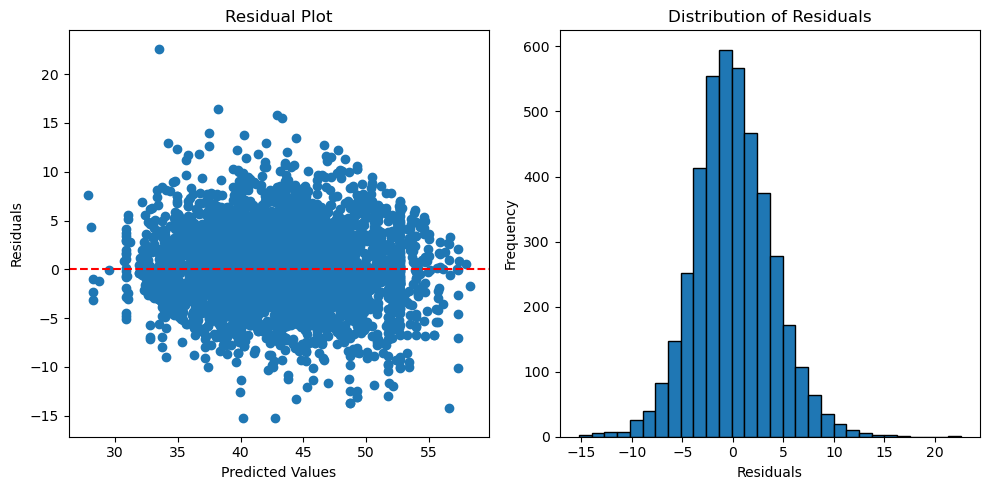

Number of outliers: 36


In [91]:
import matplotlib.pyplot as plt


# Fit Random Forest Regressor
rf = best_selector[0].best_estimator_
rf.fit(X_tr[features_selected], y_tr)

# Make predictions
y_pred = rf.predict(X_ts[features_selected])

# Calculate residuals
residuals = y_ts - y_pred

# General Performance Metrics
mse = mean_squared_error(y_ts, y_pred)
mae = mean_absolute_error(y_ts, y_pred)
r2 = r2_score(y_ts, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Visualize Residuals
plt.figure(figsize=(10, 5))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# Check for potential outliers
outliers = np.where(np.abs(residuals) > 3 * np.std(residuals))[0]
print(f'Number of outliers: {len(outliers)}')

Error Analysis by Composite Class:
     Composite_Class  Residual                                 Actual
                          mean       std        max        min  count
0         CP II-E_40 -0.288583  4.026924   9.848636 -12.949164    170
1        CP II-F _40 -0.415529  3.062269   5.940429  -5.154340     15
2         CP II-F_40 -0.132705  3.598147  16.384226 -15.252318   1276
3           CP IV_32 -0.250459  3.317551  11.798598 -15.221088    321
4        CPIII RS_40  1.146062  5.211099  15.505204 -11.980761    245
5  CPV ARI RS_ARI-RS  0.073145  3.888404  22.585038 -14.159734   2212


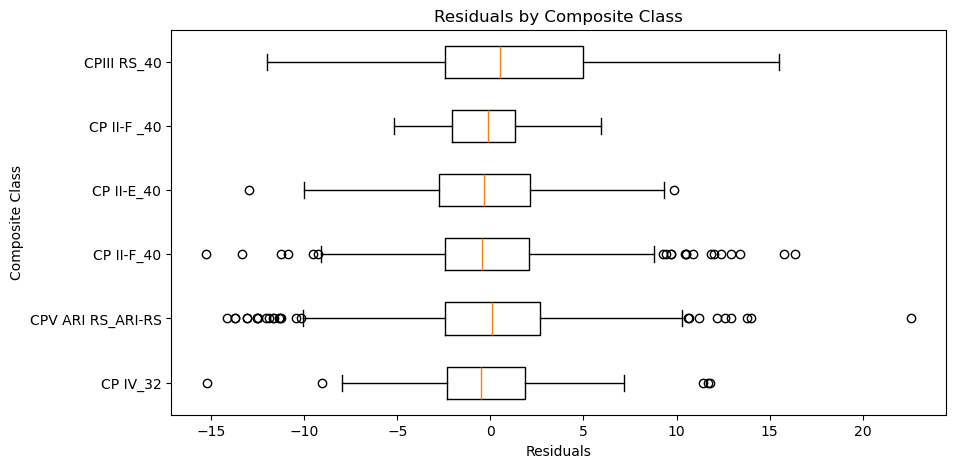

In [92]:
# Assuming 'Class1' and 'Class2' are the two columns to stratify by
class_column1 = X_ts[group_columns[0]]
class_column2 = X_ts[group_columns[1]]

# Create a composite class by combining the two columns
composite_class = class_column1.astype(str) + '_' + class_column2.astype(str)

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'Actual': y_ts,
    'Predicted': y_pred,
    'Residual': residuals,
    'Composite_Class': composite_class
})

# Analyze errors by composite class
error_by_composite_class = results_df.groupby('Composite_Class').agg({
    'Residual': ['mean', 'std', 'max', 'min'],
    'Actual': 'count'
}).reset_index()

print("Error Analysis by Composite Class:")
print(error_by_composite_class)

# Visualize error by composite class
plt.figure(figsize=(10, 5))
plt.boxplot([results_df[results_df['Composite_Class'] == cls]['Residual'] for cls in results_df['Composite_Class'].unique()],
            labels=results_df['Composite_Class'].unique(), vert=False)
plt.title('Residuals by Composite Class')
plt.ylabel('Composite Class')
plt.xlabel('Residuals')
plt.show()


# Focando no tipo de concreto/cimento

In [124]:
data_processed.groupby(['cimento Tipo', 'cimento Classe de resistência', 'CT Cimento', 'AC']).count()['Fck']

cimento Tipo  cimento Classe de resistência  CT Cimento  AC      
CPV ARI RS    ARI-RS                         271.0       0.630996     3
                                             274.0       0.638686    21
                                             276.0       0.630435     2
                                             282.0       0.638298    33
                                             284.0       0.637324     8
                                                                     ..
                                             440.0       0.500000     2
                                             447.0       0.449664     7
                                             462.0       0.450216     3
                                             480.0       0.450000     1
                                             489.0       0.449898     6
Name: Fck, Length: 310, dtype: int64

In [122]:
data_processed[data_processed.duplicated()]

,cimento Tipo,cimento Classe de resistência,Fck,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,...,Brita_total,Areia_total,Agregados,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento,Brita_total_Cimento,Areia_total_Cimento,Agregados_Cimento
16613,CPV ARI RS,ARI-RS,30.0,400.0,0.0,3.6,130.0,735.0,248.0,582.0,...,865.0,830.0,1695.0,0.325000,1.837500,0.620000,1.455000,2.162500,2.075000,4.237500
16466,CPV ARI RS,ARI-RS,30.0,361.0,0.0,0.0,936.0,0.0,460.0,309.0,...,936.0,769.0,1705.0,2.592798,0.000000,1.274238,0.855956,2.592798,2.130194,4.722992
9444,CPV ARI RS,ARI-RS,35.0,353.0,0.0,0.0,132.0,967.0,428.0,288.0,...,1099.0,716.0,1815.0,0.373938,2.739377,1.212465,0.815864,3.113314,2.028329,5.141643
8154,CPV ARI RS,ARI-RS,35.0,404.0,0.0,0.0,123.0,904.0,405.0,272.0,...,1027.0,677.0,1704.0,0.304455,2.237624,1.002475,0.673267,2.542079,1.675743,4.217822
10673,CPV ARI RS,ARI-RS,35.0,342.0,0.0,0.0,172.0,973.0,358.0,361.0,...,1145.0,719.0,1864.0,0.502924,2.845029,1.046784,1.055556,3.347953,2.102339,5.450292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16435,CPV ARI RS,ARI-RS,30.0,329.0,0.0,0.0,132.0,966.0,440.0,296.0,...,1098.0,736.0,1834.0,0.401216,2.936170,1.337386,0.899696,3.337386,2.237082,5.574468
16367,CPV ARI RS,ARI-RS,30.0,327.0,0.0,0.0,166.0,942.0,371.0,373.0,...,1108.0,744.0,1852.0,0.507645,2.880734,1.134557,1.140673,3.388379,2.275229,5.663609
12966,CPV ARI RS,ARI-RS,25.0,333.0,0.0,0.0,122.0,894.0,452.0,303.0,...,1016.0,755.0,1771.0,0.366366,2.684685,1.357357,0.909910,3.051051,2.267267,5.318318
8690,CPV ARI RS,ARI-RS,35.0,374.0,0.0,0.0,133.0,973.0,406.0,273.0,...,1106.0,679.0,1785.0,0.355615,2.601604,1.085561,0.729947,2.957219,1.815508,4.772727


In [116]:
keep_instances

,index,cimento Tipo,cimento Classe de resistência,Fck
0,0,CPV ARI RS,ARI-RS,593


In [25]:
X_tr_CPV = X_tr.reset_index()
X_tr_CPV = X_tr_CPV[X_tr_CPV['cimento Tipo'] == 'CPV ARI RS']

y_tr_CPV = y_tr.reset_index()
y_tr_CPV = y_tr_CPV[y_tr_CPV['index'].isin(X_tr_CPV['index'])]

X_tr_CPV.drop(columns = ['index'], inplace = True)
y_tr_CPV.drop(columns = ['index'], inplace = True)
y_tr_CPV = np.array(y_tr_CPV).reshape(-1,)

X_ts_CPV = X_tr.reset_index()
X_ts_CPV = X_ts_CPV[X_ts_CPV['cimento Tipo'] == 'CPV ARI RS']

y_ts_CPV = y_tr.reset_index()
y_ts_CPV = y_ts_CPV[y_ts_CPV['index'].isin(X_ts_CPV['index'])]

X_ts_CPV.drop(columns = ['index'], inplace = True)
y_ts_CPV.drop(columns = ['index'], inplace = True)
y_ts_CPV = np.array(y_ts_CPV).reshape(-1,)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [2, 10],
    'min_samples_split': [2, 5],
    }

feature_selector = grid_search_FS_RF(X_ts_CPV.drop(columns = group_columns), y_tr_CPV, param_grid_rf)

feat_importance = feature_selector[1]
features_selected = feat_importance['Feature'].tolist()[:10]

X_tr_CPV_FS = X_tr_CPV[features_selected]
X_ts_CPV_FS = X_ts_CPV[features_selected]

regression_train_val(X_tr_CPV_FS, X_ts_CPV_FS, y_tr_CPV, y_ts_CPV)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for RandomForestRegressor:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Feature Importances for the Best Model:
                        Feature  Importance
8                            AC    0.573087
2         CT Superplastificante    0.072911
1                     CT Silica    0.056427
0                    CT Cimento    0.033446
16          Brita_total_Cimento    0.031280
18            Agregados_Cimento    0.029202
10                  Areia_total    0.025798
5              CT Areia natural    0.020766
9                   Brita_total    0.019891
14     CT Areia natural_Cimento    0.018521
11                    Agregados    0.017993
7                       CT Água    0.015839
15  CT Areia artificial_Cimento    0.015731
12           CT Brita 0_Cimento    0.014931
3                    CT Brita 0    0.013058
17          Areia_total_Cimento    0.012535
6           CT Areia artificial    0.011796


In [26]:
def grid_search_RFClassifier(x_train, y_train, n_splits = 5):
    # Define the hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': [20, 100],
        'max_depth': [3, 15],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
    
    # param_grid = {
    #     'n_estimators': [20, 50, 100, 200],
    #     'max_depth': [None, 3, 5, 10, 20],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4],
    #     'bootstrap': [True, False]
    # }

    # Initialize Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform Grid Search with K-Fold Cross-Validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)

    # Fit the model on the training data
    grid_search.fit(x_train, y_train)

    return grid_search

In [27]:
rf_gridsearch_CPV = grid_search_RFClassifier(X_tr_CPV_FS, y_tr_CPV)
rf_gridsearch_CPV

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 10],
                         'n_estimators': [20, 100]},
             verbose=2)

In [28]:
def eval_regressor(X_tr, X_ts, y_tr, y_ts, regressors):  
    # Initialize the Min-Max Scaler
    scaler = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both the training and test data
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_ts)
    
    
    # Initialize a dictionary to store results
    results = {}
    
    # Train and evaluate each regressor
    for name, regressor in regressors.items():
        # Train the model
        regressor.fit(X_train_scaled, y_tr)
        
        # Make predictions
        y_pred = regressor.predict(X_test_scaled)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_ts, y_pred)
        mse = mean_squared_error(y_ts, y_pred)
        r2 = r2_score(y_ts, y_pred)
        
        # Store results
        results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results).T
    
    # Print the report
    print("Regression Algorithms Performance Report:")
    print(results_df)

In [29]:
eval_regressor(X_tr_CPV_FS, X_ts_CPV_FS, y_tr_CPV, y_ts_CPV, {'RF grid_search' : rf_gridsearch_CPV.best_estimator_})

Regression Algorithms Performance Report:
                     MAE        MSE        R2
RF grid_search  2.728438  12.430825  0.701524


In [30]:
def plot_residuals(grid_estimator, x_train, x_test, y_train, y_test, group_columns, regressors = None):
    
    feat_importance = grid_estimator[1]
    features_selected = feat_importance['Feature'].tolist()[:10]
    
    rf =  rf_gridsearch_CPV.best_estimator_ if (type(regressors) == dict) else grid_estimator[0].best_estimator_
    rf.fit(x_train[features_selected], y_train)
    
    # Make predictions
    y_pred = rf.predict(x_test[features_selected])
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # General Performance Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    
    # Visualize Residuals
    plt.figure(figsize=(10, 5))
    
    # Residual plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Histogram of Residuals
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Check for potential outliers
    outliers = np.where(np.abs(residuals) > 3 * np.std(residuals))[0]
    print(f'Number of outliers: {len(outliers)}')
    
    print(x_test.iloc[outliers].groupby(group_columns).count()['CT Cimento'])

Mean Squared Error (MSE): 12.90234429369504
Mean Absolute Error (MAE): 2.7940022222565113
R-squared (R2): 0.6902027121225052


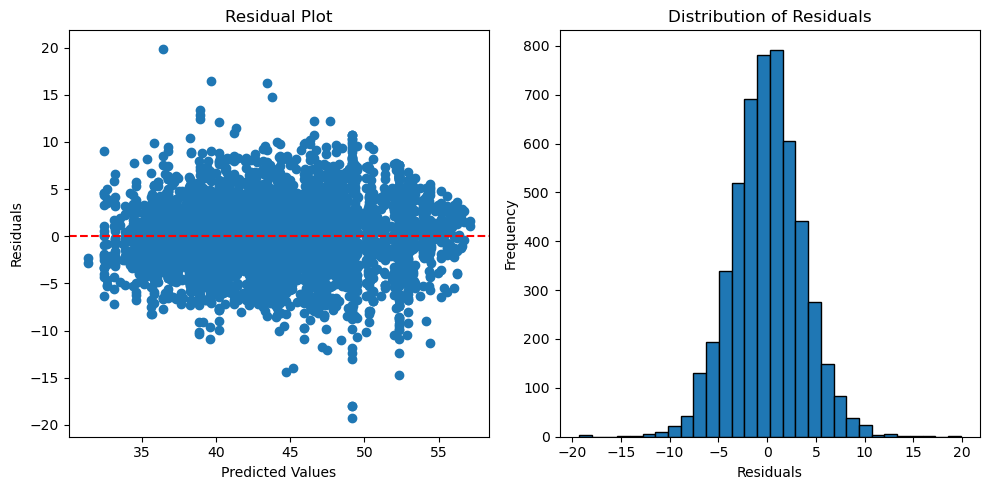

Number of outliers: 29
cimento Tipo  cimento Classe de resistência
CPV ARI RS    ARI-RS                           29
Name: CT Cimento, dtype: int64


In [31]:
plot_residuals(feature_selector, X_tr_CPV, X_ts_CPV, y_tr_CPV, y_ts_CPV, group_columns, regressors = rf_gridsearch_CPV)

In [52]:
df_CPV

,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
57738,30.0,16.0,139430.0,296.0,0.0,0.000,133.0,973.0,457.0,307.0,175.0,0.591216,21.4
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,202.0,0.500000,45.5
57760,30.0,18.0,134444.0,296.0,0.0,0.000,166.0,940.0,381.0,384.0,175.0,0.591216,23.2
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,179.0,0.600671,28.4
57774,30.0,18.7,138938.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,180.0,0.638298,26.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,183.0,0.449631,57.5
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,177.0,0.482289,47.4
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,175.0,0.593220,36.3
120822,45.0,55.1,121286.0,401.0,20.0,0.000,1072.0,0.0,377.0,253.0,198.0,0.493766,59.9


In [56]:
df_CPV.groupby('Fck').count()

,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
Fck,,,,,,,,,,,,
20.0,1,1,1,1,1,1,1,1,1,1,1,1
25.0,1577,1577,1577,1577,1577,1577,1577,1577,1577,1577,1577,1577
30.0,2957,2957,2957,2957,2957,2957,2957,2957,2957,2957,2957,2957
35.0,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861
40.0,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072
45.0,230,230,230,230,230,230,230,230,230,230,230,230


Mean Squared Error (MSE): 12.90234429369504
Mean Absolute Error (MAE): 2.7940022222565113
R-squared (R2): 0.6902027121225052


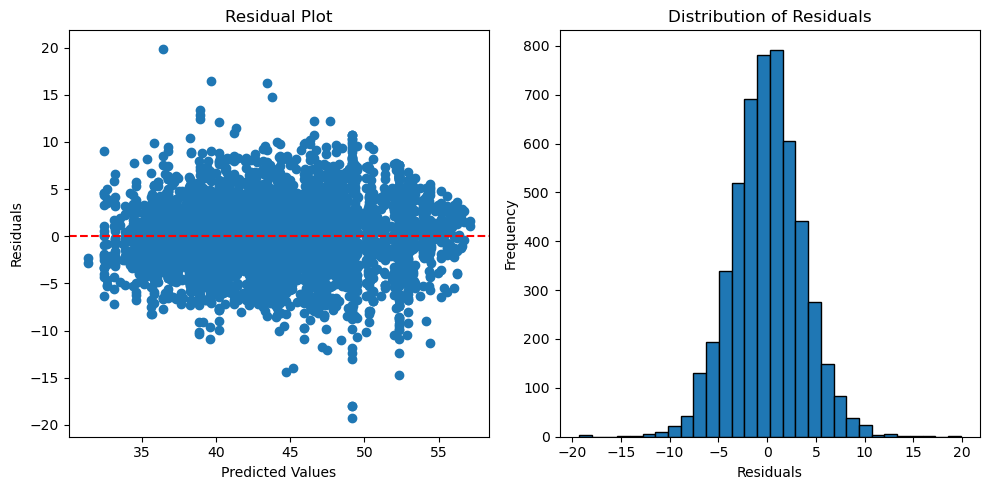

Number of outliers: 29
cimento Tipo  cimento Classe de resistência
CPV ARI RS    ARI-RS                           29
Name: CT Cimento, dtype: int64


In [53]:
grid_estimator = feature_selector
x_train = X_tr_CPV
x_test = X_ts_CPV
y_train = y_tr_CPV
y_test = y_ts_CPV
group_columns = group_columns
regressors = rf_gridsearch_CPV

feat_importance = grid_estimator[1]
features_selected = feat_importance['Feature'].tolist()[:10]

rf =  rf_gridsearch_CPV.best_estimator_ if (type(regressors) == dict) else grid_estimator[0].best_estimator_
rf.fit(x_train[features_selected], y_train)

# Make predictions
y_pred = rf.predict(x_test[features_selected])

# Calculate residuals
residuals = y_test - y_pred

# General Performance Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Visualize Residuals
plt.figure(figsize=(10, 5))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# Check for potential outliers
outliers = np.where(np.abs(residuals) > 3 * np.std(residuals))[0]
print(f'Number of outliers: {len(outliers)}')

print(x_test.iloc[outliers].groupby(group_columns).count()['CT Cimento'])

In [32]:
df_CPV = df_concreto_traco[df_concreto_traco['cimento Tipo'] == 'CPV ARI RS']
df_CPV = df_CPV[df_CPV['CT Água'] != 0]

df_CPV['AC'] = df_CPV['CT Água'] / df_CPV['CT Cimento']

df_CPV = df_CPV.iloc[:, 4:]

for c in df_CPV:
    df_CPV[c] = df_CPV[c].astype(float)

df_CPV = df_CPV[df_CPV['AC'] < 0.7]
df_CPV = df_CPV[df_CPV['Fc 28d'] < 60]
df_CPV = df_CPV[df_CPV['CT Polifuncional'] < 1]
df_CPV = df_CPV[df_CPV['CT Plastificante'] < 0.5]
# df_CPV = df_CPV[df_CPV['CT Silica'] < 1]


columns_all_zero = df_CPV.columns[(df_CPV == 0).all()]
df_CPV = df_CPV.drop(columns=columns_all_zero)

df_CPV = df_CPV[['Fck', 'Fc 7d', 'Nota Fiscal', 'CT Cimento', 'CT Silica', 'CT Superplastificante', 'CT Brita 0',
       'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'CT Água', 'AC', 'Fc 28d']]

df_CPV = df_CPV.drop_duplicates()

df_CPV

,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
57738,30.0,16.0,139430.0,296.0,0.0,0.000,133.0,973.0,457.0,307.0,175.0,0.591216,21.4
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,202.0,0.500000,45.5
57760,30.0,18.0,134444.0,296.0,0.0,0.000,166.0,940.0,381.0,384.0,175.0,0.591216,23.2
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,179.0,0.600671,28.4
57774,30.0,18.7,138938.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,180.0,0.638298,26.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,183.0,0.449631,57.5
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,177.0,0.482289,47.4
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,175.0,0.593220,36.3
120822,45.0,55.1,121286.0,401.0,20.0,0.000,1072.0,0.0,377.0,253.0,198.0,0.493766,59.9


In [33]:
run_regression(data = df_CPV,
               drop_columns = ['Fck', 'Fc 7d', 'Nota Fiscal', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.900891  24.665881  0.480455
Decision Tree Regressor      3.190138  17.214852  0.637399
Random Forest Regressor      3.186086  17.115439  0.639493
Gradient Boosting Regressor  3.499282  20.121797  0.576169


In [34]:
df_CPV_FeatEng = df_CPV.copy()

df_CPV_FeatEng['Brita_total'] = df_CPV_FeatEng['CT Brita 0'] + df_CPV_FeatEng['CT Brita 1']
df_CPV_FeatEng['Areia_total'] = df_CPV_FeatEng['CT Areia natural'] + df_CPV_FeatEng['CT Areia artificial']

for c in ['CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial']:
    df_CPV_FeatEng[c + '_Cimento'] = df_CPV_FeatEng[c] / df_CPV_FeatEng['CT Cimento']

df_CPV_FeatEng

,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d,Brita_total,Areia_total,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento
57738,30.0,16.0,139430.0,296.0,0.0,0.000,133.0,973.0,457.0,307.0,175.0,0.591216,21.4,1106.0,764.0,0.449324,3.287162,1.543919,1.037162
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,202.0,0.500000,45.5,1027.0,677.0,0.304455,2.237624,1.002475,0.673267
57760,30.0,18.0,134444.0,296.0,0.0,0.000,166.0,940.0,381.0,384.0,175.0,0.591216,23.2,1106.0,765.0,0.560811,3.175676,1.287162,1.297297
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,179.0,0.600671,28.4,1116.0,755.0,0.449664,3.295302,1.516779,1.016779
57774,30.0,18.7,138938.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,180.0,0.638298,26.4,1121.0,749.0,0.595745,3.379433,1.322695,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,183.0,0.449631,57.5,1118.0,643.0,0.329238,2.417690,0.945946,0.633907
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,177.0,0.482289,47.4,1133.0,679.0,0.370572,2.716621,1.106267,0.743869
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,175.0,0.593220,36.3,1115.0,766.0,0.454237,3.325424,1.552542,1.044068
120822,45.0,55.1,121286.0,401.0,20.0,0.000,1072.0,0.0,377.0,253.0,198.0,0.493766,59.9,1072.0,630.0,2.673317,0.000000,0.940150,0.630923


In [35]:
run_regression(data = df_CPV_FeatEng,
               drop_columns = ['Fck', 'Fc 7d', 'Nota Fiscal', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.842298  23.970678  0.495099
Decision Tree Regressor      3.194152  17.214616  0.637404
Random Forest Regressor      3.187022  17.104625  0.639720
Gradient Boosting Regressor  3.477924  19.877275  0.581319


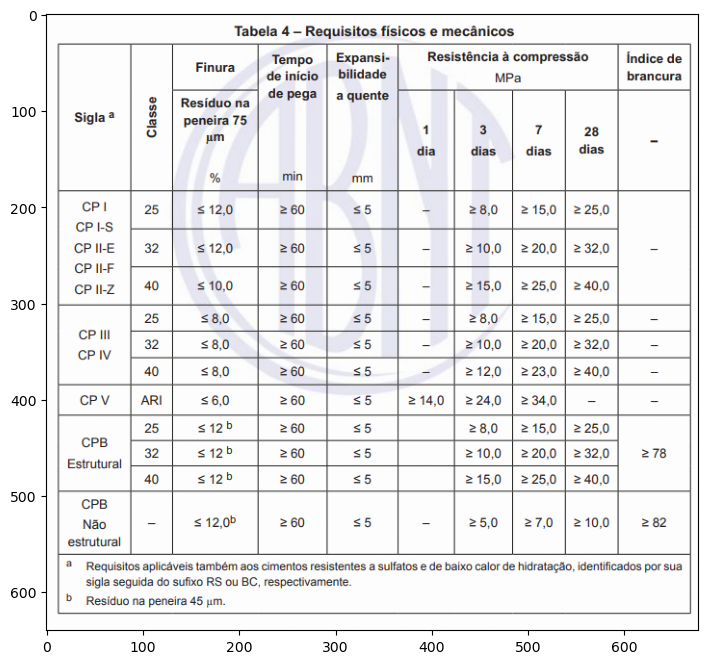

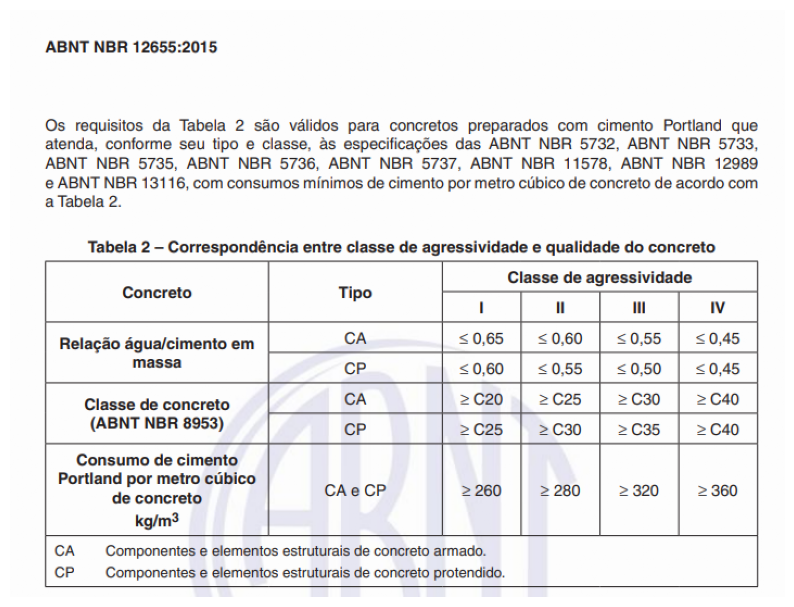

Compressive strength for CP V:
7_days: 24.0


In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread('imgs/nbr16697.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)

img = mpimg.imread('imgs/nbr12655.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)

plt.axis('off')  # Hide axes
plt.show()

def NBR_compressive_strength(concrete_class, age_days):
    # Dictionary to hold compressive strength data at 3, 7, and 28 days for each class
    compressive_strength = {
        'CP I': {'3_days': 8.0, '7_days': 15.0, '28_days': 25.0},
        'CP I-S': {'3_days': 10.0, '7_days': 20.0, '28_days': 32.0},
        'CP I-E': {'3_days': 10.0, '7_days': 20.0, '28_days': 32.0},
        'CP II-F': {'3_days': 10.0, '7_days': 20.0, '28_days': 32.0},
        'CP II-Z': {'3_days': 10.0, '7_days': 20.0, '28_days': 32.0},
        'CP III': {'3_days': 10.0, '7_days': 18.0, '28_days': 25.0},
        'CP IV': {'3_days': 14.0, '7_days': 23.0, '28_days': 40.0},
        'CP V': {'3_days': 14.0, '7_days': 24.0, '28_days': 34.0},
    }

    # Get the compressive strength for the specified class
    if concrete_class in compressive_strength:
        return compressive_strength[concrete_class][age_days]
    else:
        return "Concrete class/age not found"

# Example usage:
concrete_class = 'CP V'
age = '7_days'
strength = NBR_compressive_strength(concrete_class, age)
print(f"Compressive strength for {concrete_class}:\n{age}: {strength}")

In [37]:
concrete_class = 'CP V'
age = '7_days'


# Feature analysed: 'Fck'
print('Instâncias eliminadas devido a falta de representatividade (Fck = 20MPA):\t', len(df_CPV[df_CPV['Fck'] == 20]))
df_CPV_processed = df_CPV[df_CPV['Fck'] != 20].copy()

print('Instâncias eliminadas devido a falta de representatividade (Fck = 45MPA):\t', len(df_CPV_processed[df_CPV_processed['Fck'] == 45]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['Fck'] != 45]


# Feature analysed: 'AC'
print('Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):\t\t\t\t', len(df_CPV_processed[df_CPV_processed['AC'] > 0.65]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['AC'] <= 0.65]

# Feature analysed: 'Fc 28d'
## Precisa de análise mais detalhada!!!
df_CPV_processed['Status'] = np.where(df_CPV_processed['Fc 28d'] >= df_CPV_processed['Fck'], 1, 0)
print('Instâncias eliminadas devido não conformidade resistência especificada:\t\t', len(df_CPV_processed[df_CPV_processed['Status'] == 0]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['Status'] == 1]


# df_CPV_processed['Brita_total'] = df_CPV_processed['CT Brita 0'] + df_CPV_processed['CT Brita 1']
# df_CPV_processed['Areia_total'] = df_CPV_processed['CT Areia natural'] + df_CPV_processed['CT Areia artificial']
# df_CPV_processed['Agregados'] = df_CPV_processed['Brita_total'] + df_CPV_processed['Areia_total']
# 
# for c in ['CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'Brita_total', 'Areia_total',
#           'Agregados']:
#     df_CPV_processed[c + '_Cimento'] = df_CPV_processed[c] / df_CPV_processed['CT Cimento']

df_CPV_processed

Instâncias eliminadas devido a falta de representatividade (Fck = 20MPA):	 1
Instâncias eliminadas devido a falta de representatividade (Fck = 45MPA):	 230
Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):				 423
Instâncias eliminadas devido não conformidade resistência especificada:		 508


,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d,Status
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,202.0,0.500000,45.5,1
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,179.0,0.600671,28.4,1
57808,25.0,20.5,138929.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,185.0,0.600649,28.5,1
57813,30.0,20.7,138352.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,180.0,0.638298,30.3,1
57828,25.0,21.0,139006.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,185.0,0.600649,28.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120762,35.0,51.5,104530.0,369.0,0.0,2.214,123.0,900.0,458.0,308.0,190.0,0.514905,56.2,1
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,183.0,0.449631,57.5,1
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,177.0,0.482289,47.4,1
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,175.0,0.593220,36.3,1


In [38]:
for fck in df_CPV_processed['Fck'].unique():
    df_fck = df_CPV_processed[df_CPV_processed['Fck'] == fck]
    print(f'\nExperiment for fck{fck}, with {len(df_fck)} samples:')    
    run_regression(data = df_fck,
                   drop_columns = ['Fck', 'Fc 7d', 'Nota Fiscal', 'Status', 'Fc 28d'],
                   target = 'Fc 28d')

print(f'\nExperiment with all ({len(df_CPV_processed)}) samples:')      
run_regression(data = df_CPV_processed,
                   drop_columns = ['Fck', 'Fc 7d', 'Nota Fiscal', 'Status', 'Fc 28d'],
                   target = 'Fc 28d')


Experiment for fck35.0, with 4590 samples:
Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.454648  18.503960  0.388521
Decision Tree Regressor      2.954478  14.080363  0.534703
Random Forest Regressor      2.969493  14.229025  0.529790
Gradient Boosting Regressor  3.095131  15.164775  0.498867

Experiment for fck25.0, with 1230 samples:
Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.303004  17.517847  0.185172
Decision Tree Regressor      3.089722  16.270778  0.243179
Random Forest Regressor      3.084827  16.208395  0.246081
Gradient Boosting Regressor  3.105968  16.184102  0.247210

Experiment for fck30.0, with 2759 samples:
Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.447965  19.207930  0.179152
Decision Tree Regressor      3.003

In [39]:
run_regression_CV(data = df_CPV_processed[['AC',
                                         'CT Cimento',
                                         'CT Areia natural',
                                         'CT Areia artificial',
                                         'CT Brita 1',
                                         'CT Brita 0',
                                        'Fc 28d']],
                   drop_columns = [],
                   target = 'Fc 28d')

Regression Algorithms Performance Report:
                                      MAE           MSE        R2
Linear Regression            1.064628e-14  2.047375e-28  1.000000
Decision Tree Regressor      1.646578e-03  5.077547e-04  0.999988
Random Forest Regressor      1.741457e-03  4.267042e-04  0.999990
Gradient Boosting Regressor  3.569671e-02  2.641763e-03  0.999937


In [40]:
df_CPIII_IV = df_concreto_traco[(df_concreto_traco['cimento Tipo'].str.contains('CP III')) | (df_concreto_traco['cimento Tipo'].str.contains('CP IV'))]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Água'] != 0]

df_CPIII_IV['AC'] = df_CPIII_IV['CT Água'] / df_CPIII_IV['CT Cimento']

df_CPIII_IV = df_CPIII_IV.iloc[:, 2:]

for c in df_CPIII_IV:
    try:
        df_CPIII_IV[c] = df_CPIII_IV[c].astype(float)
    except:
        # df_CPIII_IV[c] = df_CPIII_IV[c]
        print(f'Feature {c} não é numerica\n')

df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['AC'] < 0.65]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['Fc 28d'] < 60]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Polifuncional'] < 1]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Plastificante'] < 0.5]
# df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Silica'] < 1]


columns_all_zero = df_CPIII_IV.columns[(df_CPIII_IV == 0).all()]
df_CPIII_IV = df_CPIII_IV.drop(columns=columns_all_zero)


df_CPIII_IV = df_CPIII_IV[['cimento Tipo', 'cimento Classe de resistência', 'Fck', 'Fc 7d', 'CT Cimento', 'CT Brita 0',
       'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'CT Água', 'AC', 'Fc 28d']]


run_regression(data = df_CPIII_IV,
               drop_columns = ['cimento Tipo', 'cimento Classe de resistência', 'Fck', 'Fc 7d', 'Fc 28d'],
               target = 'Fc 28d')

Feature cimento Tipo não é numerica

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.645020  22.003427  0.227079
Decision Tree Regressor      2.695662  12.783029  0.550967
Random Forest Regressor      2.651849  11.846789  0.583854
Gradient Boosting Regressor  2.702759  12.552357  0.559069


In [41]:
concrete_class = 'CP III'
age = '7_days'


# Feature analysed: 'Fck'
print(f'{"Instâncias eliminadas devido a falta de representatividade (Fck =25 MPA):" :<90}', len(df_CPIII_IV[df_CPIII_IV['Fck'] == 25]))
df_CPIII_IV_processed = df_CPIII_IV[df_CPIII_IV['Fck'] != 25].copy()


# Feature analysed: 'AC'
print(f'{"Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):" :<90}', len(df_CPIII_IV_processed[df_CPIII_IV_processed['AC'] > 0.65]))
df_CPIII_IV_processed = df_CPIII_IV_processed[df_CPIII_IV_processed['AC'] <= 0.65]

# Feature analysed: 'Fc 28d'
## Precisa de análise mais detalhada!!!
df_CPIII_IV_processed['Status'] = np.where(df_CPIII_IV_processed['Fc 28d'] >= df_CPIII_IV_processed['Fck'], 1, 0)
print(f'{"Instâncias eliminadas devido não conformidade resistência especificada:" : <90}', len(df_CPIII_IV_processed[df_CPIII_IV_processed['Status'] == 0]))
df_CPIII_IV_processed = df_CPIII_IV_processed[df_CPIII_IV_processed['Status'] == 1]


# df_CPIII_IV_processed['Brita_total'] = df_CPIII_IV_processed['CT Brita 0'] + df_CPIII_IV_processed['CT Brita 1']
# df_CPIII_IV_processed['Areia_total'] = df_CPIII_IV_processed['CT Areia natural'] + df_CPIII_IV_processed['CT Areia artificial']
# df_CPIII_IV_processed['Agregados'] = df_CPIII_IV_processed['Brita_total'] + df_CPIII_IV_processed['Areia_total']
# 
# for c in ['CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'Brita_total', 'Areia_total',
#           'Agregados']:
#     df_CPIII_IV_processed[c + '_Cimento'] = df_CPIII_IV_processed[c] / df_CPIII_IV_processed['CT Cimento']

df_CPIII_IV_processed

Instâncias eliminadas devido a falta de representatividade (Fck =25 MPA):                  51
Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):         0
Instâncias eliminadas devido não conformidade resistência especificada:                    269


,cimento Tipo,cimento Classe de resistência,Fck,Fc 7d,CT Cimento,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d,Status
92539,CP IV,32.0,35.0,22.7,354.0,1029.0,0.0,400.0,420.0,179.0,0.505650,35.5,1
92546,CP IV,32.0,35.0,23.1,354.0,1029.0,0.0,400.0,420.0,179.0,0.505650,37.0,1
92566,CP IV,32.0,30.0,23.9,280.0,1017.0,0.0,445.0,467.0,180.0,0.642857,31.4,1
92602,CP IV,32.0,30.0,25.4,264.0,217.0,874.0,432.0,453.0,170.0,0.643939,30.6,1
92644,CP IV,32.0,30.0,26.7,264.0,217.0,874.0,432.0,453.0,170.0,0.643939,32.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186546,CP IV,32.0,30.0,0.0,375.0,971.0,0.0,358.0,382.0,218.0,0.581333,44.2,1
186547,CP IV,32.0,35.0,0.0,408.0,971.0,0.0,342.0,366.0,218.0,0.534314,35.5,1
186548,CP IV,32.0,35.0,0.0,423.0,908.0,0.0,335.0,372.0,218.0,0.515366,48.3,1
186549,CP IV,32.0,35.0,0.0,431.0,960.0,0.0,338.0,375.0,230.0,0.533643,36.9,1


In [42]:
data = df_CPIII_IV_processed
drop_columns = ['Fck', 'Fc 7d', 'cimento Tipo', 'cimento Classe de resistência', 'Status', 'Fc 28d']
target = 'Fc 28d'

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

X = data.drop(drop_columns, axis=1)
y = data[target]

best_selector = grid_search_FS_RF(X, y, param_grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for RandomForestRegressor:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Feature Importances for the Best Model:
               Feature  Importance
3     CT Areia natural    0.349217
6                   AC    0.238065
0           CT Cimento    0.158700
4  CT Areia artificial    0.144754
1           CT Brita 0    0.051568
5              CT Água    0.032926
2           CT Brita 1    0.024770


In [43]:
feat_importance = best_selector[1]
features_selected = feat_importance[feat_importance['Importance'] > 0.05]['Feature'].tolist()
features_selected

['CT Areia natural', 'AC', 'CT Cimento', 'CT Areia artificial', 'CT Brita 0']

In [44]:
print(f'\nExperiment with all ({len(df_CPV_processed)}) samples:')

run_regression_CV(data = df_CPIII_IV[features_selected + ['Fc 28d']],
               drop_columns = [],
               target = 'Fc 28d')


Experiment with all (10536) samples:
Regression Algorithms Performance Report:
                                      MAE           MSE        R2
Linear Regression            4.480930e-15  4.003187e-29  1.000000
Decision Tree Regressor      1.801576e-02  1.328617e-02  0.999515
Random Forest Regressor      1.507188e-02  1.047474e-02  0.999619
Gradient Boosting Regressor  4.063050e-02  9.094950e-03  0.999671


In [45]:
concrete_class = 'CP V'
age = '7_days'


# Feature analysed: 'Fck'
print('Instâncias eliminadas devido a falta de representatividade (Fck = 20MPA):\t', len(df_CPV[df_CPV['Fck'] == 20]))
df_CPV_processed = df_CPV[df_CPV['Fck'] != 20].copy()

print('Instâncias eliminadas devido a falta de representatividade (Fck = 45MPA):\t', len(df_CPV_processed[df_CPV_processed['Fck'] == 45]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['Fck'] != 45]


# Feature analysed: 'AC'
print('Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):\t\t\t\t', len(df_CPV_processed[df_CPV_processed['AC'] > 0.65]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['AC'] <= 0.65]


# Feature analysed: 'Fc 28d'
## Precisa de análise mais detalhada!!!
df_CPV_processed['Status'] = np.where(df_CPV_processed['Fc 28d'] >= df_CPV_processed['Fck'], 1, 0)
print('Instâncias eliminadas devido não conformidade resistência especificada:\t\t', len(df_CPV_processed[df_CPV_processed['Status'] == 0]))
df_CPV_processed = df_CPV_processed[df_CPV_processed['Status'] == 1]

df_CPV_processed

Instâncias eliminadas devido a falta de representatividade (Fck = 20MPA):	 1
Instâncias eliminadas devido a falta de representatividade (Fck = 45MPA):	 230
Instâncias eliminadas devido não conformidade NBR6118:2023 (relação água/cimento):				 423
Instâncias eliminadas devido não conformidade resistência especificada:		 508


,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d,Status
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,202.0,0.500000,45.5,1
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,179.0,0.600671,28.4,1
57808,25.0,20.5,138929.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,185.0,0.600649,28.5,1
57813,30.0,20.7,138352.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,180.0,0.638298,30.3,1
57828,25.0,21.0,139006.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,185.0,0.600649,28.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120762,35.0,51.5,104530.0,369.0,0.0,2.214,123.0,900.0,458.0,308.0,190.0,0.514905,56.2,1
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,183.0,0.449631,57.5,1
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,177.0,0.482289,47.4,1
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,175.0,0.593220,36.3,1


In [46]:
data = df_CPV_processed
drop_columns = ['Fck', 'Fc 7d', 'Nota Fiscal', 'Status', 'Fc 28d']
target = 'Fc 28d'

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

X = data.drop(drop_columns, axis=1)
y = data[target]

best_selector = grid_search_FS_RF(X.iloc[:100, :], y.iloc[:100], param_grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for RandomForestRegressor:  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

Feature Importances for the Best Model:
                 Feature  Importance
8                     AC    0.367007
0             CT Cimento    0.225434
5       CT Areia natural    0.125315
6    CT Areia artificial    0.118586
4             CT Brita 1    0.088529
3             CT Brita 0    0.050954
7                CT Água    0.024176
1              CT Silica    0.000000
2  CT Superplastificante    0.000000


In [47]:
feat_importance = best_selector[1]
features_selected = feat_importance[feat_importance['Importance'] > 0.05]['Feature'].tolist()
features_selected

['AC',
 'CT Cimento',
 'CT Areia natural',
 'CT Areia artificial',
 'CT Brita 1',
 'CT Brita 0']

In [48]:
print(f'\nExperiment with all ({len(df_CPV_processed)}) samples:')      
run_regression(data = df_CPV_processed[features_selected + ['Fc 28d']],
                   drop_columns = [],
                   target = 'Fc 28d')


Experiment with all (10536) samples:
Regression Algorithms Performance Report:
                                      MAE           MSE        R2
Linear Regression            1.797824e-14  4.694613e-28  1.000000
Decision Tree Regressor      2.149232e-03  3.314724e-04  0.999992
Random Forest Regressor      3.121368e-03  1.828771e-03  0.999955
Gradient Boosting Regressor  3.630868e-02  2.800821e-03  0.999931


In [49]:
df_CPV_processed[features_selected + ['Fc 28d']].columns

Index(['AC', 'CT Cimento', 'CT Areia natural', 'CT Areia artificial',
       'CT Brita 1', 'CT Brita 0', 'Fc 28d'],
      dtype='object')

In [50]:
df_CPV_processed['Brita_total'] = df_CPV_processed['CT Brita 0'] + df_CPV_processed['CT Brita 1']
df_CPV_processed['Areia_total'] = df_CPV_processed['CT Areia natural'] + df_CPV_processed['CT Areia artificial']
df_CPV_processed['Agregados'] = df_CPV_processed['Brita_total']  + df_CPV_processed['Areia_total']

for c in ['CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'Brita_total', 'Areia_total', 'Agregados']:
    df_CPV_processed[c + '_Cimento'] = df_CPV_processed[c] / df_CPV_processed['CT Cimento']
    
df_CPV_processed

,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,...,Brita_total,Areia_total,Agregados,CT Brita 0_Cimento,CT Brita 1_Cimento,CT Areia natural_Cimento,CT Areia artificial_Cimento,Brita_total_Cimento,Areia_total_Cimento,Agregados_Cimento
57751,35.0,16.9,143514.0,404.0,0.0,0.000,123.0,904.0,405.0,272.0,...,1027.0,677.0,1704.0,0.304455,2.237624,1.002475,0.673267,2.542079,1.675743,4.217822
57773,25.0,18.7,143812.0,298.0,0.0,0.000,134.0,982.0,452.0,303.0,...,1116.0,755.0,1871.0,0.449664,3.295302,1.516779,1.016779,3.744966,2.533557,6.278523
57808,25.0,20.5,138929.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,...,1104.0,742.0,1846.0,0.896104,2.688312,1.441558,0.967532,3.584416,2.409091,5.993506
57813,30.0,20.7,138352.0,282.0,0.0,0.000,168.0,953.0,373.0,376.0,...,1121.0,749.0,1870.0,0.595745,3.379433,1.322695,1.333333,3.975177,2.656028,6.631206
57828,25.0,21.0,139006.0,308.0,0.0,0.000,276.0,828.0,444.0,298.0,...,1104.0,742.0,1846.0,0.896104,2.688312,1.441558,0.967532,3.584416,2.409091,5.993506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120762,35.0,51.5,104530.0,369.0,0.0,2.214,123.0,900.0,458.0,308.0,...,1023.0,766.0,1789.0,0.333333,2.439024,1.241192,0.834688,2.772358,2.075881,4.848238
120772,40.0,51.8,127218.0,407.0,0.0,0.000,134.0,984.0,385.0,258.0,...,1118.0,643.0,1761.0,0.329238,2.417690,0.945946,0.633907,2.746929,1.579853,4.326781
120784,40.0,52.2,117361.0,367.0,0.0,0.000,136.0,997.0,406.0,273.0,...,1133.0,679.0,1812.0,0.370572,2.716621,1.106267,0.743869,3.087193,1.850136,4.937330
120796,30.0,52.7,124306.0,295.0,0.0,0.000,134.0,981.0,458.0,308.0,...,1115.0,766.0,1881.0,0.454237,3.325424,1.552542,1.044068,3.779661,2.596610,6.376271


In [51]:
sns.boxplot(data = df_CPV_processed, x = 'Agregados_Cimento', hue = 'Fck')

NameError: name 'sns' is not defined

In [102]:
df_CPV_processed.groupby('Fck').count()

,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
Fck,,,,,,,,,,,,
25.0,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441
30.0,2798,2798,2798,2798,2798,2798,2798,2798,2798,2798,2798,2798
35.0,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835
40.0,2071,2071,2071,2071,2071,2071,2071,2071,2071,2071,2071,2071
45.0,230,230,230,230,230,230,230,230,230,230,230,230


In [79]:
df_CPV_processed[df_CPV_processed['CT Cimento'] == df_CPV_processed['CT Cimento'].max()]

,Fck,Fc 7d,Nota Fiscal,CT Cimento,CT Silica,CT Superplastificante,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
116982,40.0,38.3,116128.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,45.1
116983,40.0,38.3,116128.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,45.1
118568,40.0,41.2,116129.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,51.5
118569,40.0,41.2,116129.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,51.5
119090,40.0,42.4,116154.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,55.4
119091,40.0,42.4,116154.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,55.4
119444,40.0,43.5,116135.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,58.6
119445,40.0,43.5,116135.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,58.6
119572,40.0,43.7,116152.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,50.7
119573,40.0,43.7,116152.0,489.0,0.0,0.0,950.0,0.0,382.0,257.0,220.0,0.449898,50.7


In [16]:
df_CPII.columns[(df_CPII == 0).all()]

NameError: name 'df_CPII' is not defined

In [43]:
df_CPII = df_concreto_traco[df_concreto_traco['cimento Tipo'].str.contains('CP II')]
df_CPII = df_CPII[df_CPII['CT Água'] != 0]

df_CPII['AC'] = df_CPII['CT Água'] / df_CPII['CT Cimento']

df_CPII = df_CPII.iloc[:, 5:]

for c in df_CPII:
    df_CPII[c] = df_CPII[c].astype(float)

# df_CPII = df_CPII[df_CPII['AC'] < 0.7]
df_CPII = df_CPII[df_CPII['Fc 28d'] < 60]
df_CPII = df_CPII[df_CPII['CT Polifuncional'] < 1]
df_CPII = df_CPII[df_CPII['CT Plastificante'] < 0.5]
# df_CPII = df_CPII[df_CPII['CT Silica'] < 1]


columns_all_zero = df_CPII.columns[(df_CPII == 0).all()]
df_CPII = df_CPII.drop(columns=columns_all_zero)

df_CPII = df_CPII[['Fck', 'Fc 7d', 'CT Cimento', 'CT Brita 0',
       'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'CT Água', 'AC', 'Fc 28d']]


df_CPII

,Fck,Fc 7d,CT Cimento,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
12080,20.0,10.8,213.0,1074.0,0.0,889.0,0.0,193.00,0.906103,19.0
12081,20.0,11.0,229.0,283.0,851.0,841.0,0.0,186.00,0.812227,20.1
12082,20.0,11.3,204.0,339.0,794.0,866.0,0.0,185.00,0.906863,17.6
12083,20.0,11.4,213.0,1074.0,0.0,889.0,0.0,193.00,0.906103,17.7
12084,20.0,11.9,204.0,339.0,794.0,866.0,0.0,185.00,0.906863,17.9
...,...,...,...,...,...,...,...,...,...,...
236402,30.0,0.0,334.0,1000.0,0.0,356.0,450.0,216.50,0.648204,32.8
236403,25.0,0.0,353.0,203.0,814.0,317.0,405.0,218.00,0.617564,31.7
236404,30.0,0.0,348.0,987.0,0.0,354.0,447.0,219.00,0.629310,35.0
236405,30.0,0.0,348.0,987.0,0.0,354.0,447.0,219.00,0.629310,33.8


In [44]:
df_CPII.describe()

,Fck,Fc 7d,CT Cimento,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
count,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000,22359.000000
mean,29.522116,24.125617,278.881971,438.624894,638.369113,492.510756,327.451228,188.993360,0.694055,33.567815
std,5.808845,9.953237,47.992989,329.746678,353.312504,170.834149,188.475652,12.410577,0.104722,7.583842
min,20.000000,0.000000,164.000000,0.000000,0.000000,258.000000,0.000000,158.140000,0.428910,10.500000
25%,25.000000,20.000000,239.000000,225.000000,623.000000,369.000000,190.000000,180.000000,0.614310,27.915000
50%,30.000000,25.300000,272.000000,322.000000,784.000000,423.000000,403.000000,188.000000,0.687861,33.100000
75%,35.000000,30.600000,312.000000,425.000000,863.000000,594.000000,455.000000,197.000000,0.767347,38.700000
max,40.000000,59.900000,452.000000,1195.000000,1228.000000,889.000000,674.000000,239.000000,1.024390,59.800000


In [30]:
run_regression(data = df_CPII,
               drop_columns = ['Fck', 'Fc 7d', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            4.320623  30.450808  0.285229
Decision Tree Regressor      3.219248  18.005080  0.577367
Random Forest Regressor      3.113112  16.491412  0.612898
Gradient Boosting Regressor  3.534266  20.848190  0.510631


In [38]:
df_concreto_traco[(df_concreto_traco['cimento Tipo'].str.contains('CP III')) | (df_concreto_traco['cimento Tipo'].str.contains('CP IV'))]

,Empresa,Planta,cimento Tipo,cimento Classe de resistência,Slump,Fck,Fc 7d,CT Cimento,CT Fíler calcário,CT Cinza volante,...,CT Polifuncional,CT Superplastificante,CT Incorporador de ar,CT Brita 0,CT Brita 1,CT Brita 2,CT Areia natural,CT Areia artificial,CT Água,Fc 28d
67097,303,AU,CP III-RS,40,140,35.0,13.30,293.0,0.0,0.0,...,0.0,0.0,0.0,212.0,849.0,0.0,286.0,559.0,181.0,26.10
67103,303,AU,CP III-RS,40,100,20.0,17.00,220.0,0.0,0.0,...,0.0,0.0,0.0,1025.0,0.0,0.0,314.0,613.0,188.0,23.55
67177,303,AU,CP III-RS,40,100,25.0,20.65,227.0,0.0,0.0,...,0.0,0.0,0.0,218.0,873.0,0.0,392.0,504.0,180.0,26.22
67184,303,AU,CP III-RS,40,120,30.0,20.81,269.0,0.0,0.0,...,0.0,0.0,0.0,322.0,751.0,0.0,375.0,482.0,187.0,25.47
67195,303,AU,CP III-RS,40,100,25.0,21.08,255.0,0.0,0.0,...,0.0,0.0,0.0,205.0,858.0,0.0,290.0,551.0,185.0,31.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186547,303,N,CP IV,32,100,35.0,0.00,408.0,0.0,0.0,...,0.0,0.0,0.0,971.0,0.0,0.0,342.0,366.0,218.0,35.50
186548,303,N,CP IV,32,100,35.0,0.00,423.0,0.0,0.0,...,0.0,0.0,0.0,908.0,0.0,0.0,335.0,372.0,218.0,48.30
186549,303,N,CP IV,32,160,35.0,0.00,431.0,0.0,0.0,...,0.0,0.0,0.0,960.0,0.0,0.0,338.0,375.0,230.0,36.90
230834,303,U,CP III,40,180,35.0,33.10,378.0,0.0,0.0,...,0.0,0.0,0.0,884.0,0.0,0.0,418.0,284.0,216.0,36.30


In [35]:
df_CPIII_IV = df_concreto_traco[(df_concreto_traco['cimento Tipo'].str.contains('CP III')) | (df_concreto_traco['cimento Tipo'].str.contains('CP IV'))]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Água'] != 0]

df_CPIII_IV['AC'] = df_CPIII_IV['CT Água'] / df_CPIII_IV['CT Cimento']

df_CPIII_IV = df_CPIII_IV.iloc[:, 5:]

for c in df_CPIII_IV:
    df_CPIII_IV[c] = df_CPIII_IV[c].astype(float)

df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['AC'] < 0.7]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['Fc 28d'] < 60]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Polifuncional'] < 1]
df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Plastificante'] < 0.5]
# df_CPIII_IV = df_CPIII_IV[df_CPIII_IV['CT Silica'] < 1]


columns_all_zero = df_CPIII_IV.columns[(df_CPIII_IV == 0).all()]
df_CPIII_IV = df_CPIII_IV.drop(columns=columns_all_zero)


df_CPIII_IV = df_CPIII_IV[['Fck', 'Fc 7d', 'CT Cimento', 'CT Brita 0',
       'CT Brita 1', 'CT Areia natural', 'CT Areia artificial', 'CT Água', 'AC', 'Fc 28d']]


df_CPIII_IV

,Fck,Fc 7d,CT Cimento,CT Brita 0,CT Brita 1,CT Areia natural,CT Areia artificial,CT Água,AC,Fc 28d
67184,30.0,20.81,269.0,322.0,751.0,375.0,482.0,187.0,0.695167,25.47
67218,30.0,21.69,269.0,322.0,751.0,375.0,482.0,187.0,0.695167,30.64
67249,30.0,22.50,262.0,108.0,974.0,291.0,569.0,178.0,0.679389,31.09
67490,30.0,26.72,276.0,214.0,856.0,330.0,520.0,184.0,0.666667,31.67
67521,30.0,27.27,276.0,214.0,856.0,330.0,520.0,184.0,0.666667,34.96
...,...,...,...,...,...,...,...,...,...,...
186546,30.0,0.00,375.0,971.0,0.0,358.0,382.0,218.0,0.581333,44.20
186547,35.0,0.00,408.0,971.0,0.0,342.0,366.0,218.0,0.534314,35.50
186548,35.0,0.00,423.0,908.0,0.0,335.0,372.0,218.0,0.515366,48.30
186549,35.0,0.00,431.0,960.0,0.0,338.0,375.0,230.0,0.533643,36.90


In [33]:
run_regression(data = df_CPIII_IV,
               drop_columns = ['Fck', 'Fc 7d', 'Fc 28d'],
               target = 'Fc 28d')

Regression Algorithms Performance Report:
                                  MAE        MSE        R2
Linear Regression            3.666361  22.549581  0.226941
Decision Tree Regressor      2.849024  14.106374  0.516396
Random Forest Regressor      2.819828  13.614017  0.533275
Gradient Boosting Regressor  2.882806  14.343631  0.508262


In [12]:


df_CPV_class = df_CPV.copy()

df_CPV_class['Status'] = np.where(df_CPV_class['Fc 28d'] >= df_CPV_class['Fck'], 1, 0)


X = df_CPV_class.drop(['Fck', 'Fc 28d'], axis=1)
y = df_CPV_class['Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the resampling methods
oversample = SMOTE(random_state=42)
undersample = RandomUnderSampler(random_state=42)

# Apply oversampling to the training data
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

# Apply undersampling to the oversampled training data
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train_oversampled, y_train_oversampled)

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Fit the scaler on the balanced training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Define the classification algorithms
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Initialize a dictionary to store results
results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T

# Print the report
print("Classification Algorithms Performance Report:")
print(results_df)

Classification Algorithms Performance Report:
                              Accuracy  Precision  Recall  F1 Score
Logistic Regression                1.0        1.0     1.0       1.0
Support Vector Classifier          1.0        1.0     1.0       1.0
Decision Tree Classifier           1.0        1.0     1.0       1.0
Random Forest Classifier           1.0        1.0     1.0       1.0
Gradient Boosting Classifier       1.0        1.0     1.0       1.0
K-Nearest Neighbors                1.0        1.0     1.0       1.0


In [13]:
np.unique(y_train_balanced, return_counts = True)

(array([0, 1]), array([13584, 13584], dtype=int64))

In [14]:
df_CPV.columns

Index(['Fck', 'Fc 7d', 'CT Cimento', 'CT Silica', 'CT Superplastificante',
       'CT Brita 0', 'CT Brita 1', 'CT Areia natural', 'CT Areia artificial',
       'CT Água', 'AC', 'Fc 28d'],
      dtype='object')

In [15]:
qwe = df_concreto_traco[df_concreto_traco['cimento Tipo'] == 'CPV ARI RS'].copy()
for c in qwe.iloc[:, 5:]:
    qwe[c] = qwe[c].astype(float)
qwe.describe()

,Empresa,Fck,Fc 7d,CT Cimento,CT Fíler calcário,CT Cinza volante,CT Escória,CT Argila calcinada,CT Silica,CT Plastificante,CT Polifuncional,CT Superplastificante,CT Incorporador de ar,CT Brita 0,CT Brita 1,CT Brita 2,CT Areia natural,CT Areia artificial,CT Água,Fc 28d
count,21320.0,21320.000000,21320.000000,21320.000000,21320.0,21320.0,21320.0,21320.0,21320.000000,21320.000000,21320.000000,21320.000000,21320.0,21320.000000,21320.000000,21320.0,21320.000000,21320.000000,21320.000000,21320.000000
mean,307.0,33.801829,35.600745,352.115385,0.0,0.0,0.0,0.0,3.290807,0.001964,1.959475,0.373856,0.0,245.671295,802.509522,0.0,415.009709,329.600469,189.201735,44.258411
std,0.0,4.959462,6.530470,39.826449,0.0,0.0,0.0,0.0,7.746381,0.075409,76.442835,0.983231,0.0,252.173853,319.201480,0.0,71.197450,74.102532,13.443447,7.925676
min,307.0,20.000000,3.900000,183.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,102.000000,0.000000,0.0,0.000000,0.000000,0.000000,17.400000
25%,307.0,30.000000,31.000000,327.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,130.000000,877.000000,0.0,381.000000,283.000000,181.000000,38.900000
50%,307.0,35.000000,35.400000,358.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,135.000000,935.000000,0.0,420.000000,308.000000,186.000000,43.800000
75%,307.0,35.000000,39.900000,380.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,166.000000,967.000000,0.0,455.000000,369.000000,194.000000,49.200000
max,307.0,45.000000,58.600000,489.000000,0.0,0.0,0.0,0.0,27.000000,3.722000,2984.000000,4.750000,0.0,1102.000000,1030.000000,0.0,662.000000,1004.000000,238.000000,78.100000
